In [1]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 475, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 475 (delta 404), reused 448 (delta 394), pack-reused 0 (from 0)
Receiving objects: 100% (475/475), 2.16 MiB | 5.11 MiB/s, done.
Resolving deltas: 100% (404/404), done.


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
import keras
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

We import the dataset we are using for the problem

In [3]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])

In [4]:
lst_ndvi = list(df_average.NDVI)

Goal: forecast the next 6 months (12 steps) from the last year (23 steps).

We are going to generate an array of x values that is going to a list of (lists of) predictors which are 23 steps (variables) in the time series and an array of y values that is going to have a list of (lists of) targets having the 12 steps following the 23 steps mentioned before.

In [147]:
n_past = 23
n_future = 1
n_total = n_past + n_future

last_index = len(lst_ndvi)
start_index = last_index - n_total

x_ndvi = []
y_ndvi = []

while start_index > 0:
  x_ndvi.append(lst_ndvi[start_index : start_index + n_past])
  y_ndvi.append(lst_ndvi[start_index + n_past : start_index + + n_total])
  start_index -= 1

x_ndvi = np.array(x_ndvi)
y_ndvi = np.array(y_ndvi)
print(x_ndvi.shape,y_ndvi.shape)
print(x_ndvi[0],y_ndvi[0],'\n',lst_ndvi[-n_total:])

(114, 23) (114, 1)
[0.24878722 0.25532555 0.27342907 0.25360088 0.32241667 0.33934254
 0.32739211 0.32080263 0.32741053 0.30295833 0.29243596 0.2873557
 0.32455263 0.44499386 0.4853307  0.35737281 0.32430921 0.27180439
 0.25947632 0.24794079 0.23704405 0.24128326 0.23409207] [0.24307621] 
 [0.2487872246696035, 0.2553255506607929, 0.2734290748898678, 0.2536008771929824, 0.3224166666666666, 0.3393425438596492, 0.3273921052631579, 0.3208026315789474, 0.3274105263157894, 0.3029583333333333, 0.2924359649122807, 0.2873557017543859, 0.3245526315789473, 0.4449938596491228, 0.4853307017543859, 0.3573728070175438, 0.3243092105263158, 0.2718043859649123, 0.2594763157894737, 0.2479407894736842, 0.2370440528634361, 0.2412832599118942, 0.2340920704845815, 0.2430762114537445]


Data must be in a 3D format (n_samples, n_timesteps, n_features). This reshape is necessary sometimes when using Keras.

It is like having a list of tables.

In [148]:
X_train, X_test, y_train, y_test = train_test_split(x_ndvi, y_ndvi,
                                                    test_size=0.2, random_state=42)
# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features)
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features)

print(X_train_rs.shape, X_test_rs.shape, y_train.shape, y_test.shape, n_samples, n_timesteps, n_features)

(91, 23, 1) (23, 23, 1) (91, 1) (23, 1) 91 23 1


### Optimization of hyperparameters.

forecast 6 from the 23 previous steps
#### Number of nodes
With 1 layer, 15 epochs, learning rate 0.01
*   1 node   | -5345.391 R2 on test data
*   5 nodes  |   -54.364
*   10 nodes |   -46.067
*   20 nodes |   -23.377
*   40 nodes |   -6.636
*   60 nodes |   -5.370
*   65 nodes |  -11.198
*   70 nodes |  -20.670
*   80 nodes |  -13.615

With 2 layer, 15 epochs, learning rate 0.01
*   30 nodes |  -38.127
*   40 nodes |  -26.520
*   50 nodes | -122.896


With 3 layer, 15 epochs, learning rate 0.01
*   30 nodes | -221.031
*   40 nodes | -181.545
*   50 nodes | -103.414

#### Learning rate
With 2 layer, 15 epochs, 50 nodes
*   0.01 | -103.414
*   0.001 |   -8.721
*   0.0001|-5020.660

With 3 layer, 15 epochs, 40 nodes
*   0.01  |-16.532
*   0.001 | -6.474



In [149]:
random.seed(42)
batch_size = 32
num_nodes_1 = 40
num_epochs = 15
learning_rate = 0.001

simple_model = Sequential([
    InputLayer((n_timesteps,n_features)),
    LSTM(num_nodes_1, activation='tanh',input_shape=(n_timesteps, n_features)),
    Dense(y_train.shape[1]),
    ])
simple_model.summary()

simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
loss='mean_squared_error',
metrics=[RootMeanSquaredError()],
)
smod_history = simple_model.fit(X_train_rs, y_train,
                                validation_split=0.2,
                                epochs=num_epochs,
                                batch_size=batch_size,
                                shuffle = True
                                )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                      │ (None, 40)                  │           6,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,761 (26.41 KB)

 Trainable params: 6,761 (26.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354 - val_loss: 0.1483 - val_root_mean_squared_error: 0.3851
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1413 - root_mean_squared_error: 0.3753 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0856 - root_mean_squared_error: 0.2925 - val_loss: 0.0603 - val_root_mean_squared_error: 0.2456
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0516 - root_mean_squared_error: 0.2271 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1770
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0161 - root_mean_squared_error: 0.1269 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0149 - roo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
-2.013749531036735 -3.23459440409174


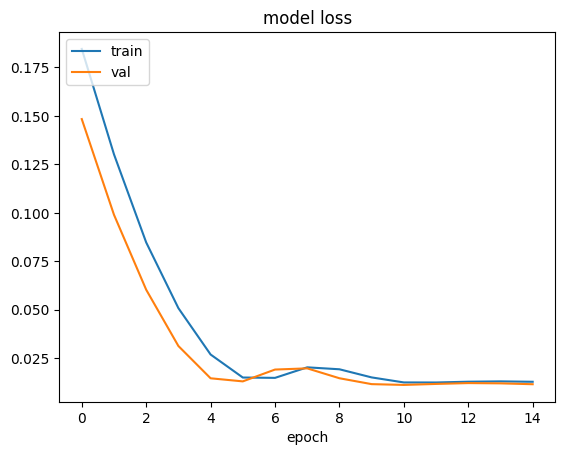

In [150]:
preds_train = simple_model.predict(X_train)
preds_test = simple_model.predict(X_test)
print(r2_score(preds_test, y_test),r2_score(preds_train, y_train))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


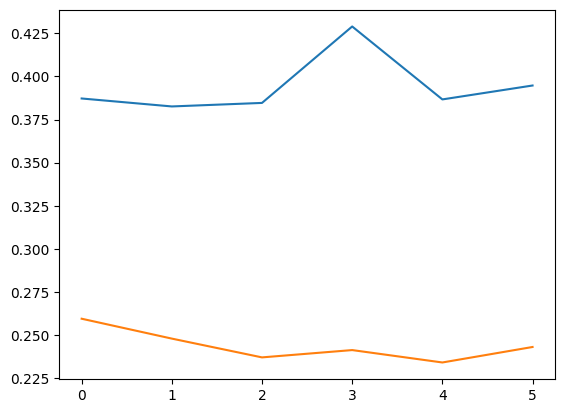

In [106]:
total_preds = simple_model.predict(x_ndvi)

plt.plot(total_preds[0])
plt.plot(y_ndvi[0])
plt.show()

In [105]:
y_ndvi

array([[0.25947632, 0.24794079, 0.23704405, 0.24128326, 0.23409207,
        0.24307621],
       [0.27180439, 0.25947632, 0.24794079, 0.23704405, 0.24128326,
        0.23409207],
       [0.32430921, 0.27180439, 0.25947632, 0.24794079, 0.23704405,
        0.24128326],
       [0.35737281, 0.32430921, 0.27180439, 0.25947632, 0.24794079,
        0.23704405],
       [0.4853307 , 0.35737281, 0.32430921, 0.27180439, 0.25947632,
        0.24794079],
       [0.44499386, 0.4853307 , 0.35737281, 0.32430921, 0.27180439,
        0.25947632],
       [0.32455263, 0.44499386, 0.4853307 , 0.35737281, 0.32430921,
        0.27180439],
       [0.2873557 , 0.32455263, 0.44499386, 0.4853307 , 0.35737281,
        0.32430921],
       [0.29243596, 0.2873557 , 0.32455263, 0.44499386, 0.4853307 ,
        0.35737281],
       [0.30295833, 0.29243596, 0.2873557 , 0.32455263, 0.44499386,
        0.4853307 ],
       [0.32741053, 0.30295833, 0.29243596, 0.2873557 , 0.32455263,
        0.44499386],
       [0.32080263, 0